# Model 3
Train deep learning algorithm and predict SCF to use in `HMASR_100km_calibration.ipynb`

Env: Julia 1.7.2

In [1]:
using Flux

In [3]:
using PyCall
using PyPlot
plt = pyimport("matplotlib.pyplot")
np = pyimport("numpy")
xr = pyimport("xarray")
pd = pyimport("pandas")
plot = pyimport("proplot")

PyObject <module 'proplot' from '/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/proplot/__init__.py'>

## Load data

In [20]:
path = "/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_100km/"

# Snow depth
ds = xr.open_mfdataset(path*"HMA_SR_D_v01_100km_WY*_SD_POST.nc")
sd = ds.SD_Post.load()

# SCF
ds = xr.open_mfdataset(path*"HMA_SR_D_v01_100km_WY*_SWE_SCA_POST.nc")
swe = ds.SWE_Post.load()
scf= ds.SCA_Post.load()


# Mask
mask = xr.open_dataarray("/home/lalandmi/Dropbox/Thèse/notebooks/SCF_parameterizations/2_calibration/Non_seasonal_snow_mask_100km.nc").load()

# Topo
# A remplacer par le fichier original en masquant les zones de neige permanente ?
# latlim = slice(mask.lat.min().values.item(0)-0.5, mask.lat.max().values.item(0)+0.5)
# lonlim = slice(mask.lon.min().values.item(0)-0.5, mask.lon.max().values.item(0)+0.5)

ds = xr.open_dataset("/home/lalandmi/Dropbox/Thèse/notebooks/SCF_parameterizations/data/HMASR_DEM_100km.nc")
topo = ds.elevation_seassnow.load()
topo_std = ds.std_seassnow.load()

PyObject <xarray.DataArray 'std_seassnow' (lat: 18, lon: 44)>
array([[        nan,         nan,         nan,         nan,         nan,
         243.05258 ,  482.3215  ,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,  413.85196 ,  378.96216 ,  746.2     ,
        1125.509   , 1208.9308  , 1269.0804  ,  984.6973  , 1002.08997 ,
         957.1579  , 1119.571   ,  740.5497  ,  486.83258 ,  295.33517 ,
         936.10974 ,  894.40814 ,  764.6612  ,  610.264   ,  580.1679  ,
                nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
         316.53333 ,  504.3908  ,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
         635.6434  ,  924.4897  , 1180.2748  , 1509.8624  ,  989.42426 ,
         400.3358  ,  467.92538 ,  360.4529  ,  323.3124  ,  396.5111  ,
         391.4363  ,  453.23746 , 1099.1914  ,  933.0921  ,  988.17914 ,
         989.61566 ,  794.53094 ,  758.6952  ,  617.0098  ,  639.4338  ,
         699.7084  ,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
         312.66617 ,  703.0128  ,  383.03174 ,  299.3294  ,         nan,
...
                nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,  355.77774 ,         nan,         nan,
                nan,         nan,         nan,         nan,  452.95453 ,
         512.8932  , 1019.94507 ,  647.7361  ,  727.51904 ,  915.9501  ,
         669.2698  ,  509.86795 ,  772.874   ,  535.6199  ,  754.7964  ,
         937.192   ,  811.8882  ,  936.8676  ,  950.8254  ,  732.1092  ,
         460.0686  ,  584.1496  ,  692.6415  ,  949.14575 ,  277.43793 ,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,  438.7599  ,  929.3737  , 1053.7167  ,
         616.1353  ,  914.7671  , 1174.0488  ,  784.9442  ,         nan,
                nan,         nan,  183.8395  ,         nan,         nan,
                nan,  407.68417 ,  388.8448  ,  490.33557 ,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 27.5 28.5 29.5 30.5 31.5 ... 40.5 41.5 42.5 43.5 44.5
  * lon      (lon) float64 61.5 62.5 63.5 64.5 65.5 ... 101.5 102.5 103.5 104.5

In [6]:
train_period = slice("1999-10-01", "2013-09-30") # ~80%
val_period = slice("2013-10-01", "2017-09-30") # ~20%

## Machine learning

In [14]:
scf

PyObject <xarray.DataArray 'SCA_Post' (time: 6575, lat: 18, lon: 44)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 61.5 62.5 63.5 64.5 65.5 ... 101.5 102.5 103.5 104.5
  * lat      (lat) float64 27.5 28.5 29.5 30.5 31.5 ... 40.5 41.5 42.5 43.5 44.5
  * time     (time) datetime64[ns] 1999-10-01 1999-10-02 ... 2017-09-30

In [ ]:
climate_2D = xr.Dataset(
        data_vars=Dict([
            ("temp", (["time","y","x"], temp_2D)),
            ("snow", (["time","y","x"], snow_2D)),
            ("rain", (["time","y","x"], rain_2D)),
            ("gradient", (["time"], climate.gradient.data))
            ]),
        coords=Dict([
            ("time", climate.time),
            ("x", g_dem.x),
            ("y", g_dem.y)
        ]),
        attrs=climate.attrs
    )


In [27]:
ds = xr.Dataset(
    data_vars=Dict([
        ("SCF", (["time", "lat", "lon"], scf)),
        ("SD", (["time", "lat", "lon"], sd)),
        ("SWE", (["time", "lat", "lon"], swe)),
        ("STD", (["lat", "lon"], topo_std)),
    ]),
    coords=Dict([
        ("time", scf.time),
        ("lat", scf.lat),
        ("lon", scf.lon),
    ])
)

PyObject <xarray.Dataset>
Dimensions:  (lat: 18, lon: 44, time: 6575)
Coordinates:
  * lat      (lat) float64 27.5 28.5 29.5 30.5 31.5 ... 40.5 41.5 42.5 43.5 44.5
  * time     (time) datetime64[ns] 1999-10-01 1999-10-02 ... 2017-09-30
  * lon      (lon) float64 61.5 62.5 63.5 64.5 65.5 ... 101.5 102.5 103.5 104.5
Data variables:
    SCF      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    STD      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    SD       (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    SWE      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [60]:
ds.sel(time=slice("2000", "2001"))

LoadError: UndefVarError: slice not defined

In [62]:
ds

PyObject <xarray.Dataset>
Dimensions:  (lat: 18, lon: 44, time: 6575)
Coordinates:
  * lat      (lat) float64 27.5 28.5 29.5 30.5 31.5 ... 40.5 41.5 42.5 43.5 44.5
  * time     (time) datetime64[ns] 1999-10-01 1999-10-02 ... 2017-09-30
  * lon      (lon) float64 61.5 62.5 63.5 64.5 65.5 ... 101.5 102.5 103.5 104.5
Data variables:
    SCF      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    STD      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    SD       (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    SWE      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [63]:
ds

PyObject <xarray.Dataset>
Dimensions:  (lat: 18, lon: 44, time: 6575)
Coordinates:
  * lat      (lat) float64 27.5 28.5 29.5 30.5 31.5 ... 40.5 41.5 42.5 43.5 44.5
  * time     (time) datetime64[ns] 1999-10-01 1999-10-02 ... 2017-09-30
  * lon      (lon) float64 61.5 62.5 63.5 64.5 65.5 ... 101.5 102.5 103.5 104.5
Data variables:
    SCF      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    STD      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    SD       (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    SWE      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [72]:
%%python
ds = ds.sel(time=slice("2000", "2001"))


The analogue of IPython's `%%python ...code...` in Julia can be constructed by first evaluating

```
macro python_str(s) open(`python`,"w",stdout) do io; print(io, s); end; end
```

to define the `python"...."` [string macro](http://docs.julialang.org/en/latest/manual/strings/#non-standard-string-literals) in Julia.  Subsequently, you can simply do:

```
python"""
...code...
"""
```

to evaluate the code in `python` (outputting to `stdout`).


In [70]:
py"""
import xarray as xr


path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_100km/'

# Snow depth
ds = xr.open_mfdataset(path+'HMA_SR_D_v01_100km_WY*_SD_POST.nc')

ds = ds.sel(time=slice("2000", "2001"))

"""

ds


PyObject <xarray.Dataset>
Dimensions:  (lat: 18, lon: 44, time: 6575)
Coordinates:
  * lat      (lat) float64 27.5 28.5 29.5 30.5 31.5 ... 40.5 41.5 42.5 43.5 44.5
  * time     (time) datetime64[ns] 1999-10-01 1999-10-02 ... 2017-09-30
  * lon      (lon) float64 61.5 62.5 63.5 64.5 65.5 ... 101.5 102.5 103.5 104.5
Data variables:
    SCF      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    STD      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    SD       (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    SWE      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [84]:
a

PyObject <xarray.DataArray 'SD_Post' (time: 731, lat: 18, lon: 44)>
dask.array<getitem, shape=(731, 18, 44), dtype=float32, chunksize=(365, 18, 44), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 61.5 62.5 63.5 64.5 65.5 ... 101.5 102.5 103.5 104.5
  * lat      (lat) float64 27.5 28.5 29.5 30.5 31.5 ... 40.5 41.5 42.5 43.5 44.5
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2001-12-31

In [83]:
a = py"ds.SD_Post"

PyObject <xarray.DataArray 'SD_Post' (time: 731, lat: 18, lon: 44)>
dask.array<getitem, shape=(731, 18, 44), dtype=float32, chunksize=(365, 18, 44), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 61.5 62.5 63.5 64.5 65.5 ... 101.5 102.5 103.5 104.5
  * lat      (lat) float64 27.5 28.5 29.5 30.5 31.5 ... 40.5 41.5 42.5 43.5 44.5
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2001-12-31

In [74]:
ds

PyObject <xarray.Dataset>
Dimensions:  (lat: 18, lon: 44, time: 6575)
Coordinates:
  * lat      (lat) float64 27.5 28.5 29.5 30.5 31.5 ... 40.5 41.5 42.5 43.5 44.5
  * time     (time) datetime64[ns] 1999-10-01 1999-10-02 ... 2017-09-30
  * lon      (lon) float64 61.5 62.5 63.5 64.5 65.5 ... 101.5 102.5 103.5 104.5
Data variables:
    SCF      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    STD      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    SD       (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    SWE      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [30]:
6575/2

3287.5

In [56]:
ds

PyObject <xarray.Dataset>
Dimensions:  (lat: 18, lon: 44, time: 6575)
Coordinates:
  * lat      (lat) float64 27.5 28.5 29.5 30.5 31.5 ... 40.5 41.5 42.5 43.5 44.5
  * time     (time) datetime64[ns] 1999-10-01 1999-10-02 ... 2017-09-30
  * lon      (lon) float64 61.5 62.5 63.5 64.5 65.5 ... 101.5 102.5 103.5 104.5
Data variables:
    SCF      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    STD      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    SD       (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    SWE      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [58]:
df_train = ds.to_dataframe()


PyObject                        SCF  STD  SD  SWE
lat  lon   time                         
27.5 61.5  1999-10-01  NaN  NaN NaN  NaN
           1999-10-02  NaN  NaN NaN  NaN
           1999-10-03  NaN  NaN NaN  NaN
           1999-10-04  NaN  NaN NaN  NaN
           1999-10-05  NaN  NaN NaN  NaN
...                    ...  ...  ..  ...
44.5 104.5 2017-09-26  NaN  NaN NaN  NaN
           2017-09-27  NaN  NaN NaN  NaN
           2017-09-28  NaN  NaN NaN  NaN
           2017-09-29  NaN  NaN NaN  NaN
           2017-09-30  NaN  NaN NaN  NaN

[5207400 rows x 4 columns]

In [57]:
df_train.head()

,lat,lon,time,SCF,STD,SD,SWE
32875,27.5,66.5,1999-10-01,0.0,243.052582,0.0,0.0
32876,27.5,66.5,1999-10-02,0.0,243.052582,0.0,0.0
32877,27.5,66.5,1999-10-03,0.0,243.052582,0.0,0.0
32878,27.5,66.5,1999-10-04,0.0,243.052582,0.0,0.0
32879,27.5,66.5,1999-10-05,0.0,243.052582,0.0,0.0


In [55]:
df_train = df_train.dropna()

,lat,lon,time,SCF,STD,SD,SWE
npartitions=1,,,,,,,
0,float64,float64,datetime64[ns],float32,float32,float32,float32
5207399,...,...,...,...,...,...,...


In [59]:
df_train = ds.to_dataframe()
df_train = df_train.dropna()
df_train.reset_index(inplace=true)
train_dataset = df_train[["SCF", "SWE", "SD", "STD"]]
x_train = train_dataset.copy()
y_train = x_train.pop("SCF")
x_train_norm = (x_train - x_train.mean()) / x_train.std()
x_train_arr, y_train_arr = np.array(x_train_norm), np.array(y_train)

LoadError: MethodError: no method matching getindex(::PyObject, ::Vector{String})
[0mClosest candidates are:
[0m  getindex(::PyObject, [91m::Integer[39m) at ~/julia-1.7.2-linux-x86_64/julia-1.7.2/share/julia/base/deprecated.jl:70
[0m  getindex(::PyObject, [91m::Integer[39m, [91m::Integer[39m) at ~/julia-1.7.2-linux-x86_64/julia-1.7.2/share/julia/base/deprecated.jl:70
[0m  getindex(::PyObject, [91m::T[39m) where T<:Union{AbstractString, Symbol} at ~/.julia/packages/PyCall/7a7w0/src/PyCall.jl:341
[0m  ...

In [9]:
df_train = ds.sel(time=train_period).to_dataframe()
df_test = ds.sel(time=val_period).to_dataframe()

In [10]:
df_train = df_train.dropna()
df_test = df_test.dropna()

df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

train_dataset = df_train[["SCF", "SWE", "SD", "STD"]]
test_dataset = df_test[["SCF", "SWE", "SD", "STD"]]

train_weights = df_train[["weights"]]
test_weights = df_test[["weights"]]

x_train = train_dataset.copy()
x_test = test_dataset.copy()

y_train = x_train.pop("SCF")
y_test = x_test.pop("SCF")

x_train_norm = (x_train - x_train.mean()) / x_train.std()
x_test_norm = (x_test - x_train.mean()) / x_train.std()

x_train_arr, y_train_arr = np.array(x_train_norm), np.array(y_train)
x_test_arr,  y_test_arr  = np.array(x_test_norm),  np.array(y_test)

In [44]:
# Define the networks 
model = Chain(
    Dense(1, 16, relu), 
    Dense(16, 32, relu), 
    Dense(32, 16, relu), 
    Dense(16, 1, sigmoid), 
)

Chain(Dense(1, 16, relu), Dense(16, 32, relu), Dense(32, 16, relu), Dense(16, 1, σ))

PyObject <xarray.DataArray 'SD_Post' (time: 6575, lat: 18, lon: 44)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 61.5 62.5 63.5 64.5 65.5 ... 101.5 102.5 103.5 104.5
  * lat      (lat) float64 27.5 28.5 29.5 30.5 31.5 ... 40.5 41.5 42.5 43.5 44.5
  * time     (time) datetime64[ns] 1999-10-01 1999-10-02 ... 2017-09-30

In [52]:
x = collect(Iterators.flatten(sd.values))

5207400-element Vector{Float32}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [53]:
x[!isnan(x)]

LoadError: MethodError: no method matching isnan(::Vector{Float32})
[0mClosest candidates are:
[0m  isnan([91m::Complex[39m) at ~/julia-1.7.2-linux-x86_64/julia-1.7.2/share/julia/base/complex.jl:147
[0m  isnan([91m::FixedPointNumbers.Normed[39m) at ~/.julia/packages/FixedPointNumbers/870tH/src/normed.jl:123
[0m  isnan([91m::ForwardDiff.Dual[39m) at ~/.julia/packages/ForwardDiff/jJIvy/src/dual.jl:352
[0m  ...

In [47]:
model(sd)

LoadError: MethodError: no method matching (::Dense{typeof(relu), TrackedArray{…,Matrix{Float32}}, TrackedArray{…,Vector{Float32}}})(::PyObject)
[0mClosest candidates are:
[0m  (::Dense{<:Any, W})([91m::AbstractArray{T}[39m) where {T<:Union{Float32, Float64}, W<:(AbstractArray{T})} at ~/.julia/packages/Flux/qXNjB/src/layers/basic.jl:110
[0m  (::Dense{<:Any, W})([91m::AbstractArray{<:Real}[39m) where {T<:Union{Float32, Float64}, W<:(AbstractArray{T})} at ~/.julia/packages/Flux/qXNjB/src/layers/basic.jl:113
[0m  (::Dense)([91m::AbstractArray[39m) at ~/.julia/packages/Flux/qXNjB/src/layers/basic.jl:97

In [11]:
def get_model_v1(shape):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape, name="InputLayer"))
    model.add(tf.keras.layers.Dense(16, activation="relu", name="Dense_n1"))
    model.add(tf.keras.layers.Dense(32, activation="relu", name="Dense_n2"))
    model.add(tf.keras.layers.Dense(16, activation="relu", name="Dense_n3"))
    
    # Output
    # The sigmoid actiavation allow to keep results between 0 and 1
    model.add(tf.keras.layers.Dense(1, activation="sigmoid", name="Output"))
    
    model.compile(optimizer = "adam",
                  loss      = "mse" )
    
    return model

In [12]:
input_size = len(x_train_arr[0])
model = get_model_v1( (input_size,) )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 16)                64        
                                                                 
 Dense_n2 (Dense)            (None, 32)                544       
                                                                 
 Dense_n3 (Dense)            (None, 16)                528       
                                                                 
 Output (Dense)              (None, 1)                 17        
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.save("model.h5")

In [12]:
history = model.fit(x_train_arr,
                    y_train_arr,
                    epochs          = 100,
                    batch_size      = 10,
                    verbose         = 1,
                    sample_weight=train_weights,
                    validation_data = (x_test_arr, y_test_arr, test_weights))

Epoch 1/100
267463/267463 [==============================] - 317s 1ms/step - loss: 9.6773e-06 - val_loss: 9.9209e-06
Epoch 2/100
267463/267463 [==============================] - 261s 975us/step - loss: 9.6231e-06 - val_loss: 9.7480e-06
Epoch 3/100
267463/267463 [==============================] - 261s 977us/step - loss: 9.5929e-06 - val_loss: 9.7252e-06
Epoch 4/100
267463/267463 [==============================] - 261s 975us/step - loss: 9.5697e-06 - val_loss: 9.8439e-06
Epoch 5/100
267463/267463 [==============================] - 263s 984us/step - loss: 9.5556e-06 - val_loss: 9.9825e-06
Epoch 6/100
267463/267463 [==============================] - 262s 979us/step - loss: 9.5402e-06 - val_loss: 9.9141e-06
Epoch 7/100
267463/267463 [==============================] - 263s 983us/step - loss: 9.5334e-06 - val_loss: 1.0121e-05
Epoch 8/100
267463/267463 [==============================] - 261s 975us/step - loss: 9.5222e-06 - val_loss: 9.8612e-06
Epoch 9/100
267463/267463 [=======================

In [13]:
score = model.evaluate(x_test_arr, y_test_arr, verbose=1, sample_weight=test_weights)

print("x_test / loss      : {:5.4f}".format(score[0]))
# print("x_test / mae       : {:5.4f}".format(score[1]))
print("x_test / mse       : {:5.4f}".format(score[1]))

23879/23879 [==============================] - 14s 573us/step - loss: 9.6582e-06


TypeError: 'float' object is not subscriptable

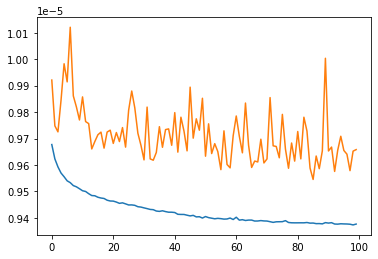

In [14]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [ ]:
df = pd.DataFrame(data=history.history)
# print("min( val_mae ) : {:.4f}".format( min(history.history["val_mean_absolute_error"]) ) )
df.plot()

In [15]:
df = ds.to_dataframe()
df = df.dropna()
df.reset_index(inplace=True)
df_subset = df[["SCF", "SWE", "SD", "STD"]]
df_subset.pop("SCF")
df_val_norm = (df_subset - x_train.mean()) / x_train.std()
x_val_arr = np.array(df_val_norm)
y_out = model.predict(x_val_arr)

In [16]:
temp = ds.to_dataframe()
df_param = temp.dropna()
df_param["SCF"] = y_out
scf_param = xr.Dataset.from_dataframe(df_param).SCF.transpose("time", "lat", "lon")

/tmp/ipykernel_16892/2276827923.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_param['SCF'] = y_out


In [17]:
scf_param.to_netcdf("results/scf_100km_ML3.nc")

In [18]:
model.save_weights("weights/scf_100km_ML3_weights.h5")